In [91]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.preprocessing import StandardScaler


In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
df_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GB_ML_Busines/Lection4/data.csv')
df_data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [94]:
df_data.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df_data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [95]:
df_data['treatment'] = np.where(df_data['treatment'] == 'No Offer', 0, 1)
df_data['treatment'].unique()

array([1, 0])

### Разделение на train и test 

In [96]:
X_train, X_val, y_train, y_val, treat_train, treat_val = train_test_split(df_data.drop(columns=['treatment', 'target']), 
                                                                          df_data['target'], 
                                                                          df_data['treatment'], 
                                                                          test_size=0.3, random_state=42)

### Feature engineering

In [97]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [98]:
continuos_cols = ['recency','history',]
cat_cols = ['zip_code','channel']
base_cols = ['used_discount', 'used_bogo','is_referral']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [99]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[ 0.35099566,  0.75403071,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [-1.35937805,  0.52773036,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.78925348, -0.39788353,  0.        , ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [ 0.63605795,  0.9819766 ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [-0.21912891, -0.66453869,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [-0.78925348,  2.13769124,  0.        , ...,  1.        ,
         1.        ,  1.        ]])

### uplift-моделированиe

In [100]:
models_results = {
    'approach': [],
    'uplift@20%': [],
    'uplift@10%': []
}

In [101]:
# !pip install scikit-uplift==0.2.0
# !pip install catboost

### Одна модель с признаком коммуникации

In [102]:
from time import thread_time
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier


classifier = Pipeline([
    ('features',feats),
    ('classifier', SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))),
])

classifier.fit(X_train, y_train, classifier__treatment=treat_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('recency',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='recency')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('history',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='history')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('zip_code',
                                                 Pipeline(steps=[('selector',
                            

In [103]:
uplift_sm = classifier.predict(X_val)

sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('SoloModel')
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@10%'].append(sm_score_10)

### Трансформация классов

In [104]:
from sklift.models import ClassTransformation

classifier = Pipeline([
    ('features',feats),
    ('classifier', ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))),
])
classifier.fit(X_train, y_train, classifier__treatment=treat_train)
uplift_ct = classifier.predict(X_val)

ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('ClassTransformation')
models_results['uplift@20%'].append(ct_score_20)
models_results['uplift@10%'].append(ct_score_10)


### Две независимые модели

In [105]:
from sklift.models import TwoModels

classifier = Pipeline([
    ('features',feats),
    ('classifier', TwoModels(
                                estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
                                estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
                                method='vanilla'
                            )),
])

classifier.fit(X_train, y_train, classifier__treatment=treat_train)
uplift_tm = classifier.predict(X_val)

tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('TwoModels')
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@10%'].append(tm_score_10)


In [106]:
pd.DataFrame(data=models_results)

,approach,uplift@20%,uplift@10%
0,SoloModel,0.089230,0.092338
1,ClassTransformation,0.087438,0.100365
2,TwoModels,0.088863,0.097845


In [107]:
features = [col for col in X_train]

cat_features = ['zip_code', 'channel']
encode_columns = pd.get_dummies(X_train[cat_features])
X_train = X_train.join(encode_columns).drop(cat_features, axis=1)

In [108]:
# !pip install causalml

CPU times: user 4.07 s, sys: 97.8 ms, total: 4.17 s
Wall time: 6.51 s


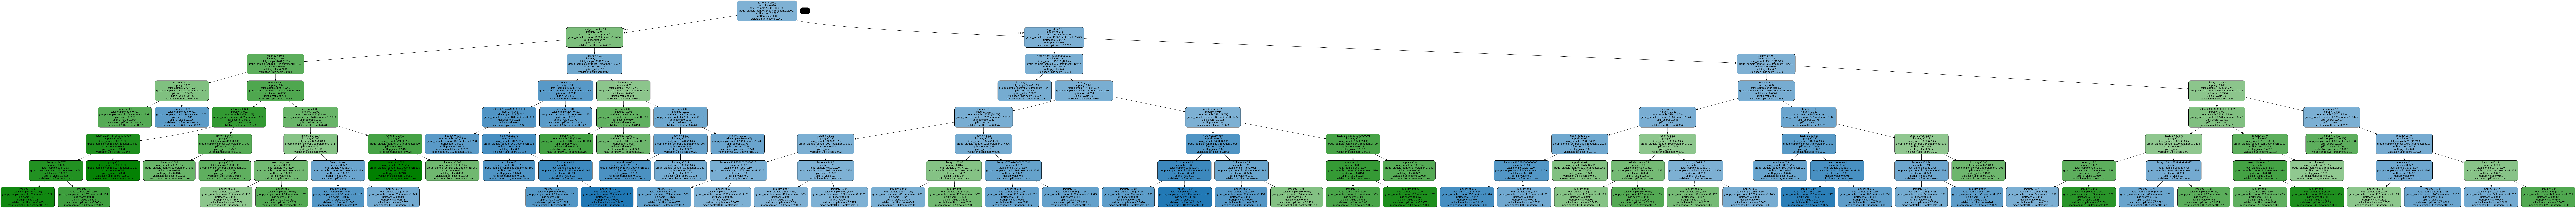

In [109]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())